In [ ]:
import pickle
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [ ]:
import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Paths to videos
REAL_VIDEOS_PATH = # Path to real videos for training
FAKE_VIDEOS_PATH = # Path to fake videos for training

# Paths to save extracted frames
OUTPUT_REAL_FRAMES = # Path to save real frames for training
OUTPUT_FAKE_FRAMES = # Path to save fake frames for training

# Create directories if not exist
os.makedirs(OUTPUT_REAL_FRAMES, exist_ok=True)
os.makedirs(OUTPUT_FAKE_FRAMES, exist_ok=True)

In [ ]:
# Extract frames from videopath and save to outputfolder with frame_interval of 5 seconds
def extract_frames(video_path, output_folder, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_interval == 0:  # Extract every nth frame
            frame_name = f"{os.path.basename(video_path).split('.')[0]}_frame{frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)

        success, frame = cap.read()
        frame_count += 1

    cap.release()

In [ ]:
# Extract frames from REAL videos
for video_file in tqdm(glob.glob(os.path.join(REAL_VIDEOS_PATH, "*.mov"))):
    extract_frames(video_file, OUTPUT_REAL_FRAMES)

# Extract frames from FAKE videos
for video_file in tqdm(glob.glob(os.path.join(FAKE_VIDEOS_PATH, "*.avi"))):
    extract_frames(video_file, OUTPUT_FAKE_FRAMES)

print("Frame extraction completed!")

In [ ]:
OUTPUT_REAL_FRAMES = (r"celebdf+ff++\train\real") # Path of saved real frames for training
OUTPUT_FAKE_FRAMES = (r"celebdf+ff++\train\fake") # Path of saved fake frames for training

In [ ]:
print(f"Total Real Frames: {len(os.listdir(OUTPUT_REAL_FRAMES))}")
print(f"Total Fake Frames: {len(os.listdir(OUTPUT_FAKE_FRAMES))}")

In [ ]:
IMG_SIZE = 128  # Resize images to 128x128 (change to 224x224 for deeper networks)
TRAIN_REAL_FRAMES_PATH = (r"celebdf+ff++\train\real")
TRAIN_FAKE_FRAMES_PATH = (r"celebdf+ff++\train\fake")
TEST_REAL_FRAMES_PATH = (r"celebdf+ff++\test\real")
TEST_FAKE_FRAMES_PATH = (r"celebdf+ff++\test\fake")

In [ ]:
print(f"Total Train Real Frames: {len(os.listdir(TRAIN_REAL_FRAMES_PATH))}")
print(f"Total Train Fake Frames: {len(os.listdir(TRAIN_FAKE_FRAMES_PATH))}")
print(f"Total Test Real Frames: {len(os.listdir(TEST_REAL_FRAMES_PATH))}")
print(f"Total Test Fake Frames: {len(os.listdir(TEST_FAKE_FRAMES_PATH))}")

In [ ]:
# Data Preprocessing
def load_images_from_folder(folder, label):
    images = []
    labels = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
        img = img / 255.0  # Normalize (0-1)
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
''' # Load Real and Fake images and labels
train_real_images, train_real_labels = load_images_from_folder(TRAIN_REAL_FRAMES_PATH, label=0)  # 0 for Real
train_fake_images, train_fake_labels = load_images_from_folder(TRAIN_FAKE_FRAMES_PATH, label=1)  # 1 for Fake
test_real_images, test_real_labels = load_images_from_folder(TEST_REAL_FRAMES_PATH, label=0)  # 0 for Real
test_fake_images, test_fake_labels = load_images_from_folder(TEST_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

# Combine and Shuffle Dataset
X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

# Shuffle data
X_train, y_train, X_test, y_test = shuffle(X_train, y_train, X_test, y_test ,random_state=42)


print(f"Training Data: {X_train.shape}, Trainimg labels: {y_train.shape}, Test Data : {X_test.shape}, Test labels : {y_test.shape}") '''

In [ ]:
# Load Real and Fake images and labels
train_real_images, train_real_labels = load_images_from_folder(TRAIN_REAL_FRAMES_PATH, label=0)  # 0 for Real

In [ ]:
train_fake_images, train_fake_labels = load_images_from_folder(TRAIN_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

In [ ]:
# Combine Dataset
X_train = np.concatenate((train_real_images, train_fake_images), axis=0)

In [ ]:
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)

In [ ]:
# deleted the no more needed variables to free up memory
del train_fake_images, train_fake_labels, train_real_images, train_real_labels

In [ ]:
# Load Real images and labels
test_real_images, test_real_labels = load_images_from_folder(TEST_REAL_FRAMES_PATH, label=0)  # 0 for Real

In [ ]:
test_fake_images, test_fake_labels = load_images_from_folder(TEST_FAKE_FRAMES_PATH, label=1)  # 1 for Fake

In [ ]:
# Combine Dataset
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)

In [ ]:
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

In [ ]:
# deleted the no more needed variables to free up memory
del test_real_images, test_real_labels, test_fake_images, test_fake_labels

In [ ]:
# deleted the no more needed variables to free up memory
del IMG_SIZE, TRAIN_REAL_FRAMES_PATH, TRAIN_FAKE_FRAMES_PATH, TEST_REAL_FRAMES_PATH, TEST_FAKE_FRAMES_PATH

In [ ]:
# Shuffle data
X_train, y_train= shuffle(X_train, y_train,random_state=42)
X_test, y_test = shuffle(X_test, y_test ,random_state=42)

In [ ]:
# Data Visualization (Real and Fake Images)
plt.figure(figsize=(20,20))
for i in range(4,10):
    plt.subplot(4,10,i+1)
    plt.imshow(X_train[i])
    plt.title("Fake" if y_train[i] == 1 else "Real")
    plt.axis("off")
plt.show()

In [ ]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile Model
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

In [ ]:
# Train Model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=16,
                    verbose=1)

In [ ]:
# Save model
model.save("deepfake_detector.h5")

In [ ]:
# Load model
model = load_model("deepfake_detector.h5")

In [ ]:
# Saved History for future use
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Loaded history from saved file
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Now `loaded_history` contains the training history

In [ ]:
# Detele the no more needed variables to free up memory
del X_train,X_test,y_train,y_test

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Testing

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [2]:
# Load model
model = load_model("deepfake_detector.h5")

In [11]:
cap = cv2.VideoCapture(r"DeepfakeTIMIT\DeepfakeTIMIT\higher_quality\faks0\sa1-video-fedw0.avi")
frames = []
frame_interval = 5
frame_count = 0
ret = True
while ret:
    ret, frame = cap.read()
    if frame_count % frame_interval == 0:
        detector = MTCNN()
        faces = detector.detect_faces(frame)
        if len(faces) != 0:
            x, y, width, height = faces[0]['box']
            frame = frame[y:y + height, x:x + width]
            frame = cv2.resize(frame, (128, 128))
            frame = frame / 255.0  # Normalize
            frame = frame.astype(np.float32)
            frames.append(frame)
            print(faces)
    frame_count += 1

[{'box': [184, 111, 142, 183], 'confidence': np.float64(0.9998032450675964), 'keypoints': {'nose': [np.int64(260), np.int64(213)], 'mouth_right': [np.int64(286), np.int64(254)], 'right_eye': [np.int64(292), np.int64(182)], 'left_eye': [np.int64(225), np.int64(182)], 'mouth_left': [np.int64(233), np.int64(254)]}}]
[{'box': [185, 113, 143, 189], 'confidence': np.float64(0.9997479319572449), 'keypoints': {'nose': [np.int64(260), np.int64(213)], 'mouth_right': [np.int64(286), np.int64(256)], 'right_eye': [np.int64(292), np.int64(183)], 'left_eye': [np.int64(226), np.int64(183)], 'mouth_left': [np.int64(234), np.int64(256)]}}]
[{'box': [186, 112, 144, 190], 'confidence': np.float64(0.999401330947876), 'keypoints': {'nose': [np.int64(261), np.int64(215)], 'mouth_right': [np.int64(286), np.int64(256)], 'right_eye': [np.int64(293), np.int64(183)], 'left_eye': [np.int64(227), np.int64(183)], 'mouth_left': [np.int64(234), np.int64(255)]}}]
[{'box': [184, 110, 139, 182], 'confidence': np.float64(

In [12]:
len(frames)

18

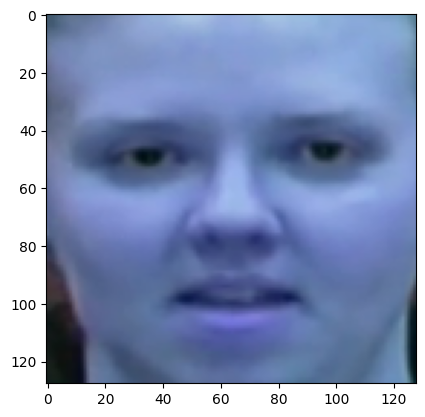

In [15]:
plt.imshow(frames[17])

In [8]:
# Function to extract frames from video provided by user
def extract_frames(video_path, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    ret, frame = cap.read()
    while ret:
        if frame_count % frame_interval == 0:
            detector = MTCNN()
            faces = detector.detect_faces(frame)
            if len(faces) != 0:
                x, y, width, height = faces[0]['box']
                frame = frame[y:y + height, x:x + width]
                frame = cv2.resize(frame, (128, 128))
                frame = frame / 255.0  # Normalize
                frame = frame.astype(np.float32)
                frames.append(frame)
                print(frame_count)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Total Frames: {len(frames)}")
    return np.array(frames)

In [4]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    predictions = model.predict(frames , batch_size=2)  # Get predictions for each frame

    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")

    # If avg_prediction > 0.5, classify as Fake; else, Real
    video_label = "Fake" if avg_prediction > 0.5 else "Real"
    print(f"Final Video Classification: {video_label}")

In [5]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize
    img = img / 255.0  # Normalize (0-1)
    img = img.astype(np.float32)

    # Add a batch dimension
    img = np.expand_dims(img, axis=0)


    predictions = model.predict(img)
    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")
    print(f"Final Classification: {"Fake" if avg_prediction > 0.5 else "Real"}")

In [6]:
def input_path(type, path):
    if type == "v" or "V":
        predict_video(path)
    elif type == "i" or "I":
        predict_image(path)
    else:
        print("Invalid Input")

In [9]:
type = input("Enter the type of input (v for video, i for image): ")
path = input("Enter the path of the video/image: ")
input_path(type,path)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
Total Frames: 18
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Average Prediction Score: 0.0042
Final Video Classification: Real


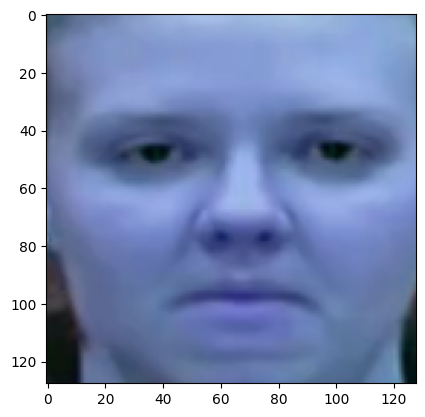

In [35]:
IMG = frames[0]
plt.imshow(IMG)

In [39]:

IMG = frames[10]
IMG = np.expand_dims(IMG, axis=0)
predictions = model.predict(IMG)
avg_prediction = np.mean(predictions)  # Average across all frames
print(f"Average Prediction Score: {avg_prediction:.4f}")
print(f"Final Classification: {"Fake" if avg_prediction > 0.5 else "Real"}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Average Prediction Score: 0.0012
Final Classification: Real
